## DFO Nutrient Comparison

In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw

%matplotlib inline

In [2]:
PATH= '/data/eolson/MEOPAR/SS36runs/CedarRuns/t15r15DiatAlpha0/'
start_date = datetime.datetime(2015,1,1)
end_date = datetime.datetime(2015,5,20)
flen=10
namfmt='long'
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T',
         'flagellates':'ptrc_T'}
fdict={'ptrc_T':1,'grid_T':1}
df1=et.loadDFO()
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,12.0,NaN,None,5.28,mg/m^3,6.6,13.6,umol/L,NaN,NaN,12.0,1982-07-16 01:21:00
1,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,21.5,NaN,None,0.61,mg/m^3,21.2,45.0,umol/L,NaN,NaN,21.5,1982-07-16 01:21:00
2,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,30.5,NaN,None,NaN,mg/m^3,23.5,47.4,umol/L,NaN,NaN,30.5,1982-07-16 01:21:00
3,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,52.3,NaN,None,NaN,mg/m^3,28.0,50.2,umol/L,NaN,NaN,52.3,1982-07-16 01:21:00
4,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,75.4,NaN,None,NaN,mg/m^3,26.5,49.1,umol/L,NaN,NaN,75.4,1982-07-16 01:21:00


In [3]:
data=et.matchData(df1,filemap, fdict, start_date, end_date, namfmt, PATH, flen)

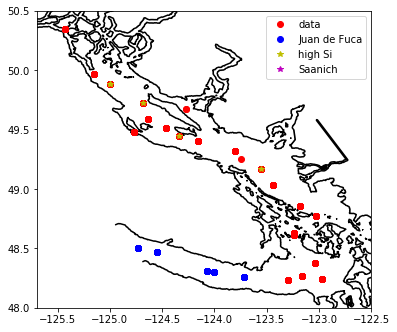

In [4]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
ax.plot(data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lon']], 
        data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lat']], 
        'bo', label = 'Juan de Fuca')

ax.plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
iSaa=(data.Lon>-123.7)&(data.Lon<-123.3)&(data.Lat>48.5)&(data.Lat<48.7)
ax.plot(data.loc[iSaa,['Lon']],data.loc[iSaa,['Lat']],'*',color='m',label='Saanich')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);
data.drop(data.loc[iSaa].index.values,inplace=True)

# Nitrate

In [5]:
N_s, modmean_s, obsmean_s, bias_s, RMSE_s, WSS_s = et.stats(data.loc[data.Z<15,['N']],data.loc[data.Z<15,['mod_nitrate']])
N_i, modmean_i, obsmean_i, bias_i, RMSE_i, WSS_i = et.stats(data.loc[(data.Z>=15)&(data.Z<22),['N']],data.loc[(data.Z>=15)&(data.Z<22),['mod_nitrate']])
N_d, modmean_d, obsmean_d, bias_d, RMSE_d, WSS_d = et.stats(data.loc[data.Z>=22,['N']],data.loc[data.Z>=22,['mod_nitrate']])
N, modmean, obsmean, bias, RMSE, WSS = et.stats(data.loc[:,['N']],data.loc[:,['mod_nitrate']])
print('Nitrate')
print('z<15 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_s,bias_s,RMSE_s,WSS_s))
print('15 m<=z<22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_i,bias_i,RMSE_i,WSS_i))
print('z>=22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d,bias_d,RMSE_d,WSS_d))
print('all:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N,bias,RMSE,WSS))

Nitrate
z<15 m:
  N: 75
  bias: -3.845753310140969
  RMSE: 6.630540012782604
  WSS: 0.7128095636536498
15 m<=z<22 m:
  N: 24
  bias: -2.5308262570699043
  RMSE: 4.114656611533365
  WSS: 0.5456750528109158
z>=22 m:
  N: 228
  bias: -3.3510210495664374
  RMSE: 3.761019057293416
  WSS: 0.7346112219814744
all:
  N: 327
  bias: -3.4042939685975426
  RMSE: 4.603134955202627
  WSS: 0.8579338178432114


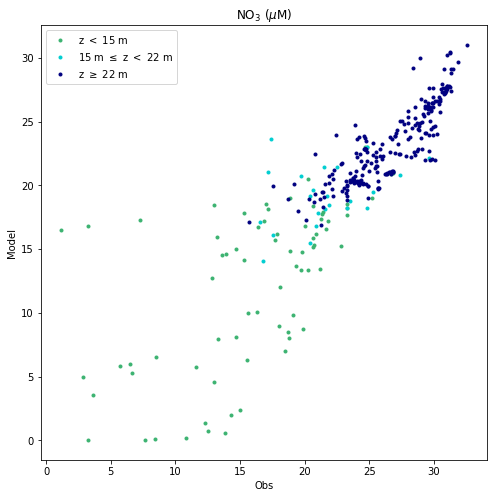

In [6]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'N','mod_nitrate','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')

Nitrate, z<15
Feb-Mar:
  N: 75
  bias: -3.845753310140969
  RMSE: 6.630540012782604
  WSS: 0.7128095636536498
April:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
May-Jun:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
Sep-Oct:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan


/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:914: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:915: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)


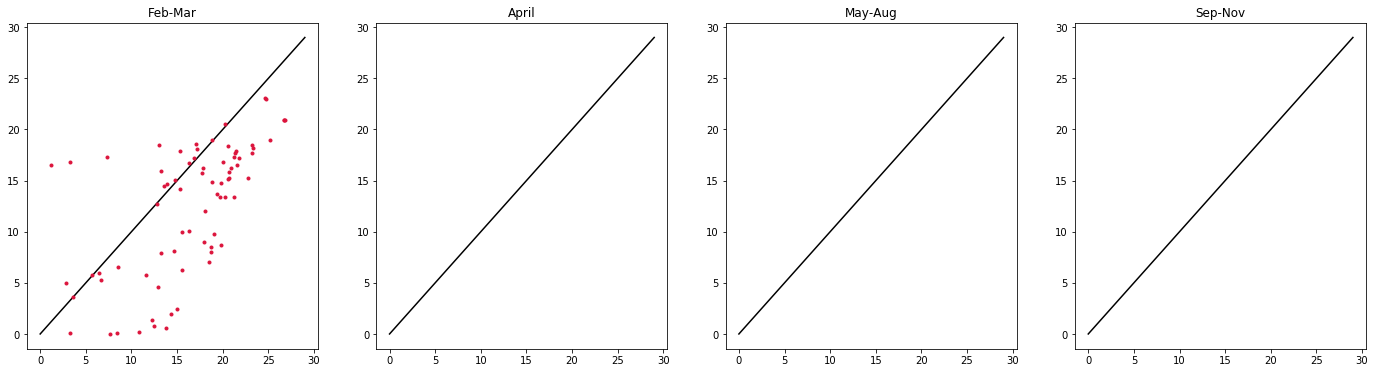

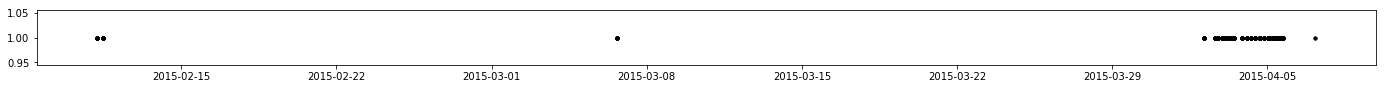

In [7]:
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,30),np.arange(0,30),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2017,4,1)),:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,5,1))&(data.dtUTC>dt.datetime(2017,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,9,1))&(data.dtUTC>dt.datetime(2017,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Aug')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,12,1))&(data.dtUTC>dt.datetime(2017,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Nov')

print('Nitrate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2017,4,1)),:],'N','mod_nitrate')
print('April:')
et.printstats(data.loc[ii1,:],'N','mod_nitrate')
print('May-Jun:')
et.printstats(data.loc[ii2,:],'N','mod_nitrate')
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],'N','mod_nitrate')
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

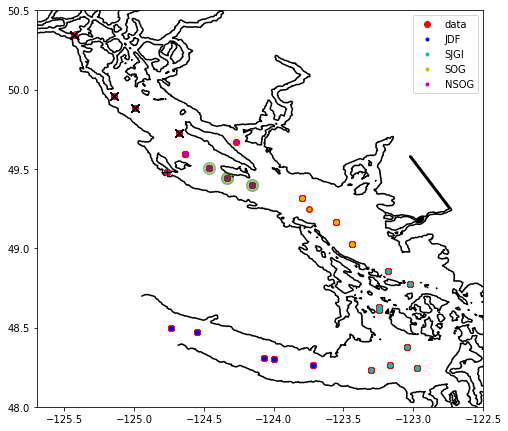

In [8]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.6)&(data.Lat<48.6)]
ax.plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax.plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax.plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax.plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);
dNSOGN=data.loc[(data.Lat>=49.7)&(data.Lon<=-124.0)]
dNSOGS=data.loc[(data.Lat<49.7)&(data.Lat>=49.1)&(data.Lon<=-124.0)]
dNSOGW=data.loc[(data.Lat>=49.1)&(data.Lon<=-124.5)]
dNSOGE=data.loc[(data.Lat>=49.1)&(data.Lon>-124.5)&(data.Lon<=-124.0)]
dBaynes=data.loc[(data.Lat>=49.35)&(data.Lat<49.7)&(data.Lon<-124.65)&(data.Lon>-125.0)]

ax.plot(dNSOGE['Lon'],dNSOGE['Lat'],'go',ms=12,alpha=.03,label='NSOGE')
ax.plot(dNSOGN['Lon'],dNSOGN['Lat'],'kx',ms=8,label='NSOGE')
ax.plot(dBaynes['Lon'],dBaynes['Lat'],'k+',ms=8,label='Baynes')

(0, 35)

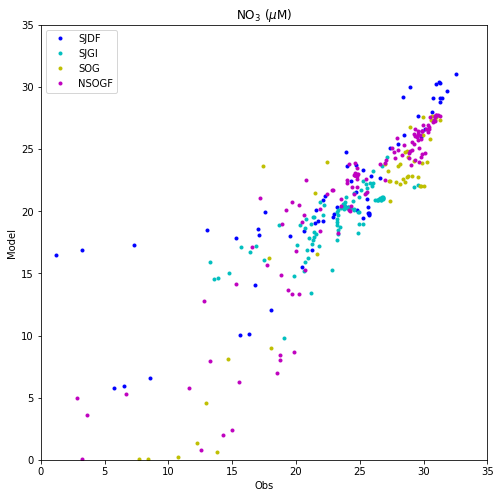

In [9]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,'N','mod_nitrate',cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,'N','mod_nitrate',cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,'N','mod_nitrate',cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,'N','mod_nitrate',cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')
ax.set_xlim(0,35)
ax.set_ylim(0,35)

(-40, 20)

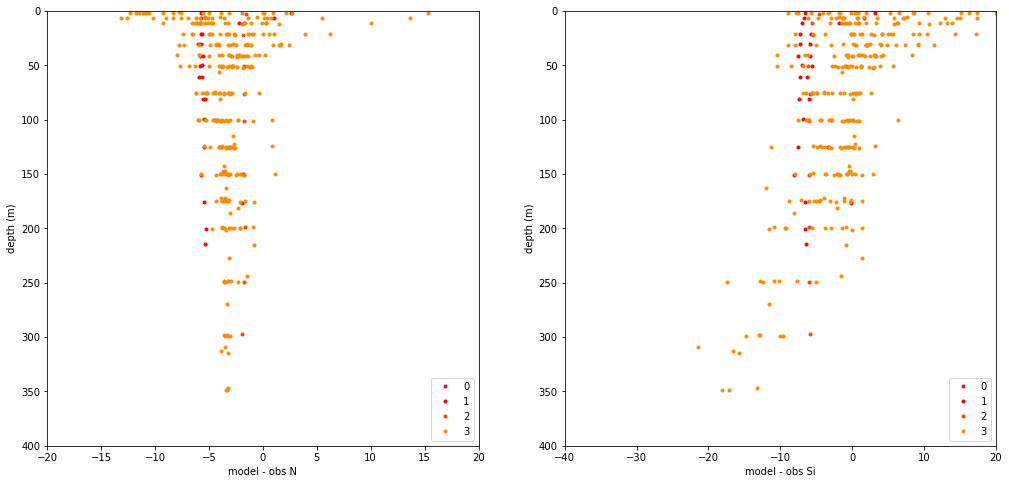

In [10]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan','darkturquoise','royalblue',
      'lightskyblue','blue','darkblue','mediumslateblue','blueviolet','darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['N']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('model - obs N')
ax[0].set_xlim(-20,20)
ax[1].set_xlabel('model - obs Si')
ax[1].set_xlim(-40,20)

# Silicate

In [11]:
print('Nitrate')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Si','mod_silicon')
print('15 m<=z<22 m:')
et.printstats(data.loc[(data.Z>=15)&(data.Z<22),:],'Si','mod_silicon')
print('z>=22 m:')
et.printstats(data.loc[data.Z>=22,:],'Si','mod_silicon')
print('all:')
et.printstats(data,'Si','mod_silicon')
print('obs Si < 50:')
et.printstats(data.loc[data.Si<50,:],'Si','mod_silicon')

Nitrate
z<15 m:
  N: 75
  bias: 3.659654286702473
  RMSE: 9.43827569106142
  WSS: 0.7640151081274053
15 m<=z<22 m:
  N: 24
  bias: 2.35601991335551
  RMSE: 6.8624174003623635
  WSS: 0.6808433456068799
z>=22 m:
  N: 228
  bias: -2.9507144499661564
  RMSE: 5.914082634448924
  WSS: 0.8908364554158057
all:
  N: 327
  bias: -1.0450897405781845
  RMSE: 6.948019822232805
  WSS: 0.8948365997305812
obs Si < 50:
  N: 239
  bias: 1.1326529980902862
  RMSE: 6.374142859134342
  WSS: 0.8239707182737246


(0, 80)

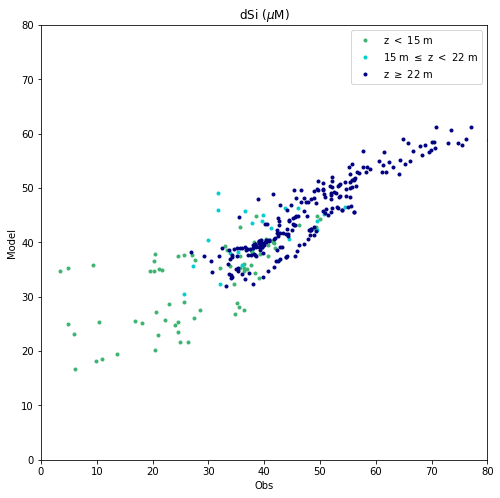

In [12]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'Si','mod_silicon','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('dSi ($\mu$M)')
ax.set_xlim(0,80)
ax.set_ylim(0,80)

Silicate, z<15
Feb-Mar:
  N: 75
  bias: 3.659654286702473
  RMSE: 9.43827569106142
  WSS: 0.7640151081274053
April:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
May-Jun:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
Sep-Oct:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan


/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:914: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:915: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)


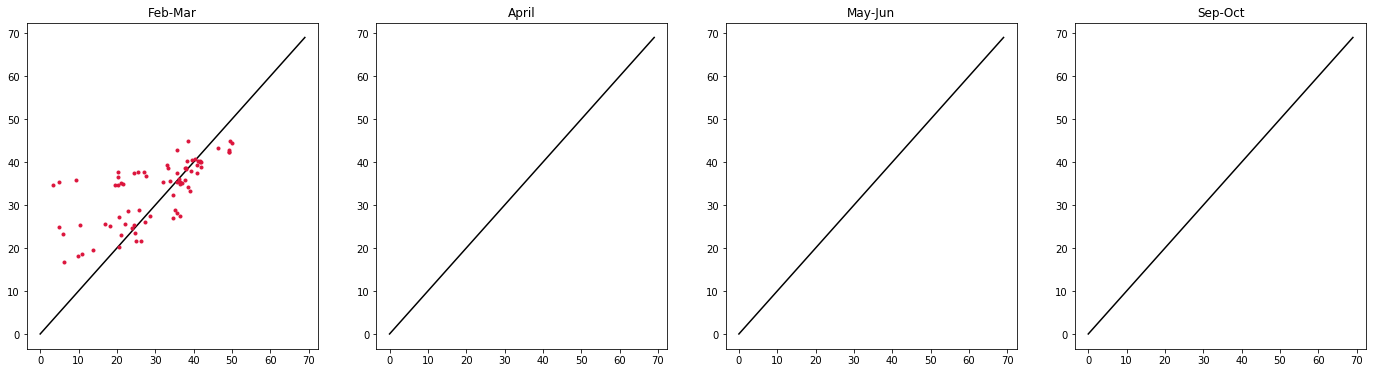

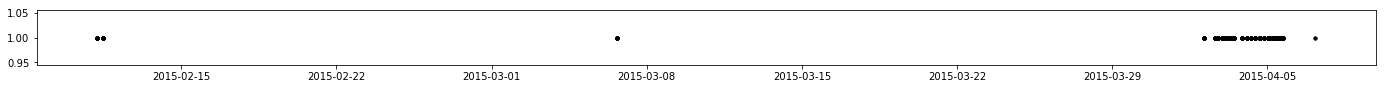

In [13]:
obsvar='Si'; modvar='mod_silicon'
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,70),np.arange(0,70),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2017,4,1)),:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,5,1))&(data.dtUTC>dt.datetime(2017,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,9,1))&(data.dtUTC>dt.datetime(2017,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,12,1))&(data.dtUTC>dt.datetime(2017,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

ii4=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,4,1))&(data.dtUTC>dt.datetime(2017,2,1))
ps=et.varvarPlot(ax[0],data.loc[ii4,:],obsvar,modvar,cols=('darkturquoise','navy'))
ii5=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,5,1))&(data.dtUTC>dt.datetime(2017,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii5,:],obsvar,modvar,cols=('darkturquoise','navy'))


print('Silicate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2017,4,1)),:],obsvar,modvar)
print('April:')
et.printstats(data.loc[ii1,:],obsvar,modvar)
print('May-Jun:')
et.printstats(data.loc[ii2,:],obsvar,modvar)
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],obsvar,modvar)
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

(0, 80)

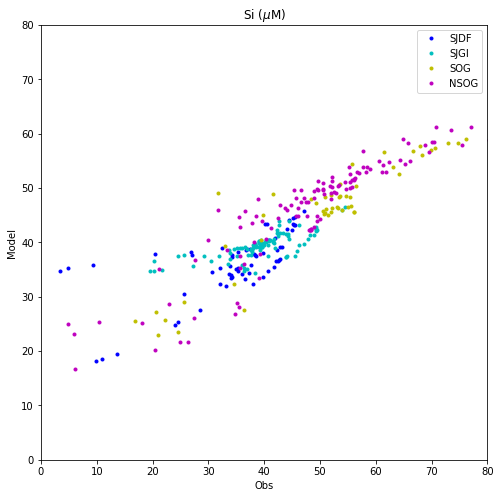

In [14]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m','darkturquoise','navy'),lname='NSOG')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('Si ($\mu$M)')
ax.set_xlim(0,80)
ax.set_ylim(0,80)

# Ratios

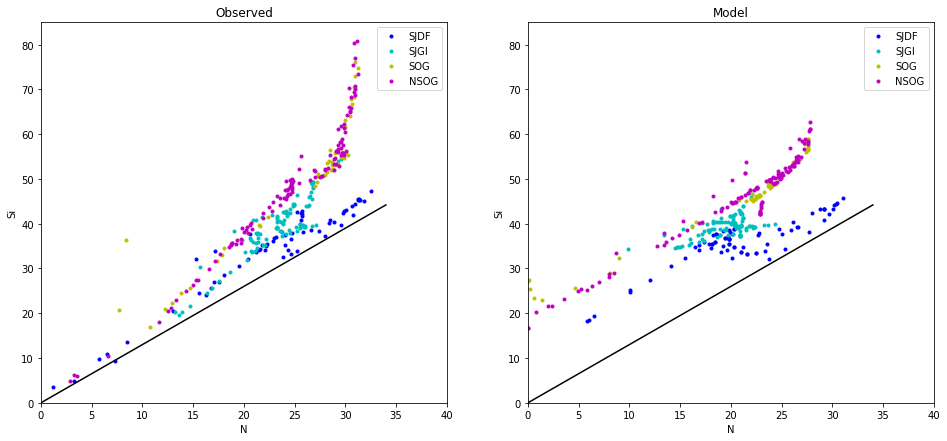

In [15]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['N'],dNSOG['Si'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Si')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_nitrate'],dNSOG['mod_silicon'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Si')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

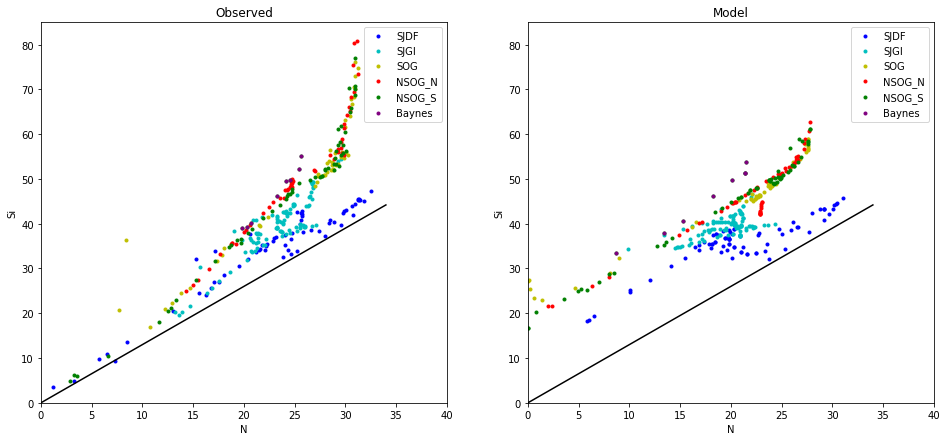

In [16]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOGN['N'],dNSOGN['Si'],'r.',label='NSOG_N')
p4=ax[0].plot(dNSOGS['N'],dNSOGS['Si'],'g.',label='NSOG_S')
p4=ax[0].plot(dBaynes['N'],dBaynes['Si'],'.',color='purple',label='Baynes')
ax[0].set_title('Observed')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Si')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOGN['mod_nitrate'],dNSOGN['mod_silicon'],'r.',label='NSOG_N')
p8=ax[1].plot(dNSOGS['mod_nitrate'],dNSOGS['mod_silicon'],'g.',label='NSOG_S')
p8=ax[1].plot(dBaynes['mod_nitrate'],dBaynes['mod_silicon'],'.',color='purple',label='Baynes')
ax[1].set_title('Model')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Si')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

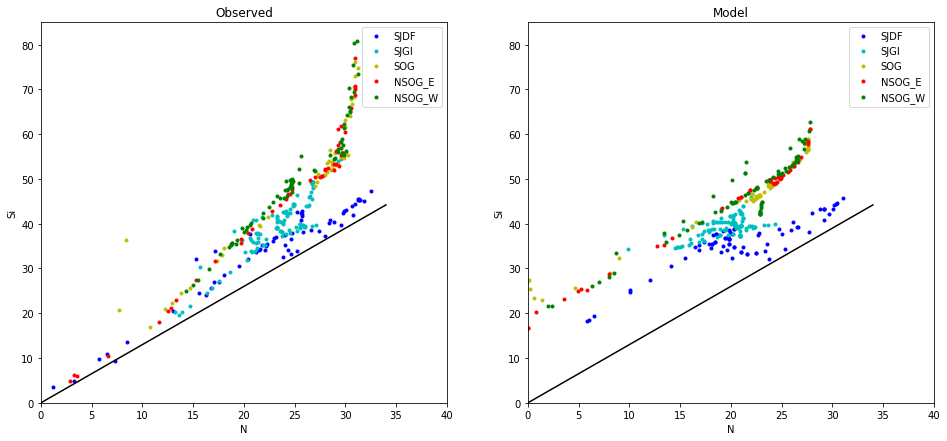

In [17]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOGE['N'],dNSOGE['Si'],'r.',label='NSOG_E')
p4=ax[0].plot(dNSOGW['N'],dNSOGW['Si'],'g.',label='NSOG_W')
ax[0].set_title('Observed')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Si')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOGE['mod_nitrate'],dNSOGE['mod_silicon'],'r.',label='NSOG_E')
p8=ax[1].plot(dNSOGW['mod_nitrate'],dNSOGW['mod_silicon'],'g.',label='NSOG_W')
ax[1].set_title('Model')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Si')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

In [18]:
data.loc[data.Si>65,['Month','Lat','Lon','Z','Si']]

,Month,Lat,Lon,Z,Si
211,4.0,49.029667,-123.436500,248.620295,67.85
212,4.0,49.029667,-123.436500,298.724014,73.00
213,4.0,49.029667,-123.436500,312.485544,74.76
227,4.0,49.163333,-123.551500,249.310468,68.35
228,4.0,49.163333,-123.551500,297.928316,69.99
229,4.0,49.163333,-123.551500,348.217366,76.12
246,4.0,49.318833,-123.799667,299.211146,66.73
247,4.0,49.318833,-123.799667,346.826687,70.58
261,4.0,49.401833,-124.156000,248.710873,65.86
262,4.0,49.401833,-124.156000,269.604692,70.17


# Chlorophyll

In [19]:
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])

In [20]:
print('log10[Chl+0.01]')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'l10_obsChl','l10_modChl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'l10_obsChl','l10_modChl')
print('all:')
et.printstats(data,'l10_obsChl','l10_modChl')
print('\n')
print('Chl')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Chlorophyll_Extracted','mod_Chl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'Chlorophyll_Extracted','mod_Chl')
print('all:')
et.printstats(data,'Chlorophyll_Extracted','mod_Chl')


log10[Chl+0.01]
z<15 m:
  N: 49
  bias: 0.20223872112646163
  RMSE: 0.5344071633892297
  WSS: 0.5069589686691476
z>=15 m:
  N: 22
  bias: 0.0787174350380348
  RMSE: 0.26464256102798417
  WSS: 0.7186566242312231
all:
  N: 71
  bias: 0.16396451980328708
  RMSE: 0.46775979254687716
  WSS: 0.6818265600969668


Chl
z<15 m:
  N: 49
  bias: 1.2835425168093368
  RMSE: 5.627767177100774
  WSS: 0.5091389584155782
z>=15 m:
  N: 22
  bias: 0.1992734926735812
  RMSE: 0.7857644716519411
  WSS: 0.6502019939387234
all:
  N: 71
  bias: 0.9475718332743139
  RMSE: 4.695667428135018
  WSS: 0.5776010417836659


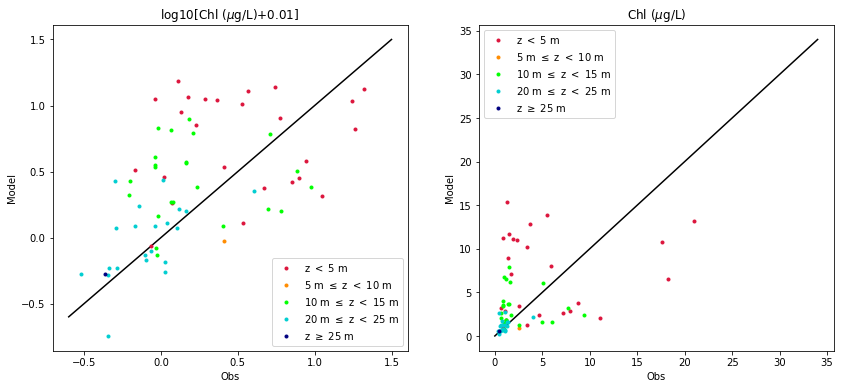

In [21]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(np.arange(-.6,1.6,.1),np.arange(-.6,1.6,.1),'k-')
ps=et.varvarPlot(ax[0],data,'l10_obsChl','l10_modChl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('log10[Chl ($\mu$g/L)+0.01]')
ax[1].plot(np.arange(0,35),np.arange(0,35),'k-')
ps=et.varvarPlot(ax[1],data,'Chlorophyll_Extracted','mod_Chl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Chl ($\mu$g/L)')